In [3]:
#use a pretrained model(week6 ADS): https://tfhub.dev/tensorflow/tfjs-model/posenet/resnet50/quantized/1/1/default/1

# Kaggle API


In [11]:
#This cell has to be runned when you want to upload the API token file to google colab, cell below if local
#if you use a local jupyter notebook the kaggle.json has to be in the following path --> C:\Users\User\.kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

ModuleNotFoundError: No module named 'google.colab'

In [4]:
#use this cell if you working local and if you work in google colab use the cell above
# Then move kaggle.json into the folder where the API expects to find it.
#!pip install kaggle 
#freigeben falls zum ersten Mal
import kaggle
#!mkdir -p ~\.kaggle\ && move kaggle.json \.kaggle\ && chmod 600 ~\.kaggle\kaggle.json 
# move anstelle von mv verwenden bei Windows

#wenn / gemäss Internet \ verwenden, da Syntax nicht korrekt, jedoch weiter Warnungen...

  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-6.1.1-py2.py3-none-any.whl (9.1 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


In [5]:
#search for a dataset
!kaggle datasets list -s 'rock-paper-scissor'


ref                                                             title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/frtgnn/rock-paper-scissor                              Rock - Paper - Scissor                        220MB  2019-11-07 17:52:43            457         81  0.6875           
datasets/drgfreeman/rockpaperscissors                           Rock-Paper-Scissors Images                    306MB  2019-03-01 01:01:11           8219        148  0.875            
datasets/sanikamal/rock-paper-scissors-dataset                  Rock Paper Scissors Dataset                   452MB  2019-04-24 19:53:04           2755         60  0.875            
datasets/glushko/rock-paper-scissors-dataset                    Rock, Paper, Scissors Data

In [17]:
#download a dataset
!kaggle datasets download -d drgfreeman/rockpaperscissors
#Name ohne '' gemacht, damit es funktioniert hat...


  0%|          | 0.00/306M [00:00<?, ?B/s]
  1%|          | 3.00M/306M [00:00<00:13, 23.9MB/s]
  2%|1         | 6.00M/306M [00:00<00:13, 23.9MB/s]
  3%|3         | 10.0M/306M [00:00<00:10, 29.7MB/s]
  5%|4         | 15.0M/306M [00:00<00:08, 34.6MB/s]
  6%|6         | 19.0M/306M [00:00<00:08, 35.9MB/s]
  8%|7         | 23.0M/306M [00:00<00:08, 36.8MB/s]
  9%|8         | 27.0M/306M [00:00<00:08, 32.7MB/s]
 10%|#         | 31.0M/306M [00:01<00:08, 32.0MB/s]
 11%|#1        | 35.0M/306M [00:01<00:08, 33.8MB/s]
 13%|#2        | 39.0M/306M [00:01<00:07, 35.5MB/s]
 14%|#4        | 44.0M/306M [00:01<00:07, 37.5MB/s]
 16%|#5        | 48.0M/306M [00:01<00:08, 32.5MB/s]
 17%|#7        | 52.0M/306M [00:01<00:07, 34.0MB/s]
 19%|#8        | 57.0M/306M [00:01<00:07, 36.4MB/s]
 20%|##        | 62.0M/306M [00:01<00:06, 38.0MB/s]
 22%|##1       | 67.0M/306M [00:02<00:06, 39.2MB/s]
 24%|##3       | 72.0M/306M [00:02<00:06, 40.2MB/s]
 25%|##5       | 77.0M/306M [00:02<00:05, 42.3MB/s]
 27%|##6       | 82.

# Scraping

In [13]:
from bs4 import BeautifulSoup
import requests

#set page url 

URL = "https://www.google.com/search?q=rock-paper-scissors+hand+sign&tbm=isch&ved=2ahUKEwiphtPg4J_3AhVN3IUKHe6hD5AQ2-cCegQIABAA&oq=rock-paper-scissors+hand+sign&gs_lcp=CgNpbWcQAzIECAAQHjIGCAAQCBAeOgcIIxDvAxAnOggIABAIEB4QEzoGCAAQBxAeOgQIABATOggIABAHEB4QEzoICAAQCBAHEB5QvgZY01VgildoEHAAeACAAfgBiAHwGJIBBjI5LjUuMpgBAKABAaoBC2d3cy13aXotaW1nwAEB&sclient=img&ei=JnleYqnbAs24lwTuw76ACQ&bih=831&biw=1680&rlz=1C5CHFA_enCH928CH928"
page = requests.get(URL)


soup = BeautifulSoup(page.content, 'html.parser')

#find all urls in img-tag <img> with class="yWs4tf"
image_tags = soup.find_all('img', class_='yWs4tf')


#add all urls to links-dict
links = []
for image_tag in image_tags:
    links.append(image_tag['src'])

#request all pictures and save

import urllib.request
for i, url in enumerate(links):
    urllib.request.urlretrieve(url, str('photo_' + str(i+1) + '.jpg'))

# Hand Classification with Transfer Learning & Fine Tuning

In [120]:
# TensorFlow and tf.keras
#!pip install tensorflow
#! pip install tensorflow_datasets
import tensorflow as tf
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import tensorflow_datasets as tfds

print(tf.__version__)
print(tf.config.list_physical_devices())

2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [121]:
#setup folder where you will save logs for tensorflow 
root_logdir = os.path.join(os.curdir,"my_logs_project")


def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [156]:
from zipfile import ZipFile
import shutil


# Create a ZipFile Object and load file.zip in it
with ZipFile('rockpaperscissors.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('rockpaperscissors')
#shutil.rmtree('\rps-cv-images') <-- funktionier bisher nicht, um 4. Ordner zu löschen
# wie kann ich 4. ordner löschen???? hier aktuell manuel vorgenommen...

In [159]:
data_dir = os.path.join(os.curdir, 'rockpaperscissors')
                        
BATCH_SIZE = 32
IMG_SIZE = (192, 192)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "training")

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            shuffle=True,
                                                            seed=999,
                                                            validation_split=0.20,
                                                            subset = "validation")


Found 2188 files belonging to 3 classes.
Using 1751 files for training.
Found 2188 files belonging to 3 classes.
Using 437 files for validation.


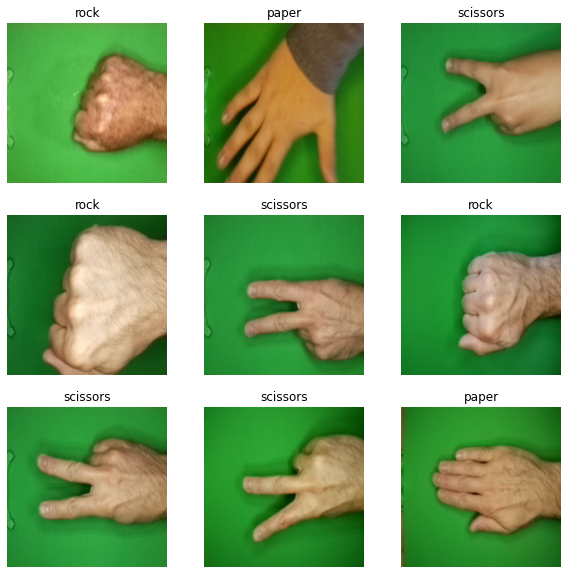

In [160]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [161]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
val_dataset = validation_dataset.skip(val_batches // 5)

In [162]:

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 14
Number of test batches: 2


In [163]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data augementation

In [164]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.RandomRotation(0.3, fill_mode='reflect', interpolation='bilinear', seed=None, fill_value=0.0) ###### INSERT HERE KERAS LAYERS TO PERFORM DATA AUGMENTAION######
    ])

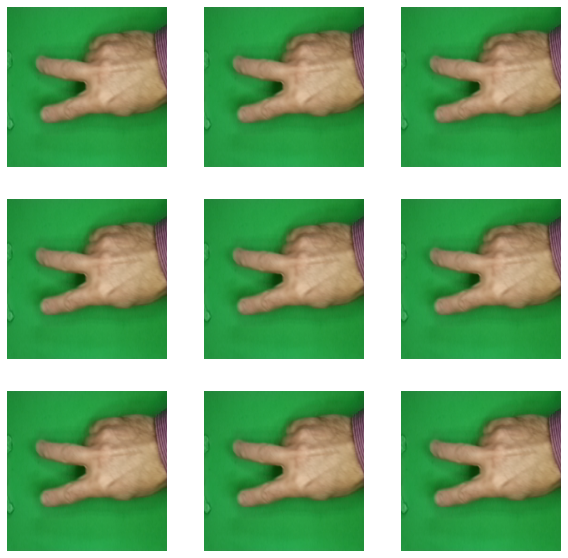

In [165]:
with tf.device('/cpu:0'):
    for image, _ in train_dataset.take(1):
      plt.figure(figsize=(10, 10))
      first_image = image[0]
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Choose Transfer Learning Model

In [166]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [167]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [168]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [169]:
base_model.trainable = False

In [170]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 96, 96, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 96, 96, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 96, 96, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 24, 24, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 24, 24, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 24, 24, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 24, 24, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 12, 12, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 12, 12, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 12, 12, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 12, 12, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 12, 12, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 12, 12, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 12, 12, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 6, 6, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 6, 6, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 6, 6, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 6, 6, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [171]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) #We need to set `training=False` as our model contains a `BatchNormalization` layer. More explanation here https://www.tensorflow.org/guide/keras/transfer_learning
x = tf.keras.layers.GlobalAveragePooling2D()(x) #this layer has the same purpose as tf.keras.layers.Flatten(). Need to connect something 2D to something 1D. Ask if you want to know more :)
x = tf.keras.layers.Dense(10, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) 
model = tf.keras.Model(inputs, outputs)

#### Compile the mode

In [172]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [173]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential_14 (Sequential)  (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 192, 192, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

### Train the model

In [174]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

14/14 [==============================] - 12s 658ms/step - loss: 1.2767 - accuracy: 0.3249


In [175]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.28
initial accuracy: 0.32


In [176]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
55/55 [==============================] - 57s 974ms/step - loss: 0.9447 - accuracy: 0.3255 - val_loss: 0.7346 - val_accuracy: 0.3249
Epoch 2/5
55/55 [==============================] - 51s 929ms/step - loss: 0.6726 - accuracy: 0.3152 - val_loss: 0.5790 - val_accuracy: 0.3570
Epoch 3/5
55/55 [==============================] - 52s 933ms/step - loss: 0.5668 - accuracy: 0.3261 - val_loss: 0.4583 - val_accuracy: 0.3638
Epoch 4/5
55/55 [==============================] - 52s 940ms/step - loss: 0.4536 - accuracy: 0.3175 - val_loss: 0.3419 - val_accuracy: 0.3638
Epoch 5/5
55/55 [==============================] - 52s 943ms/step - loss: 0.3696 - accuracy: 0.3244 - val_loss: 0.2428 - val_accuracy: 0.3638


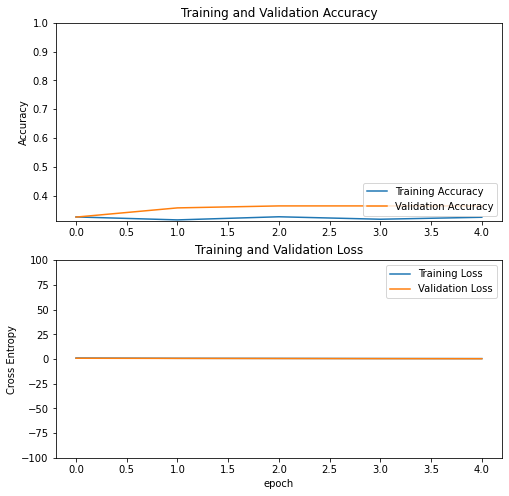

In [177]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-1.0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

In [178]:
base_model.trainable = True

In [179]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [180]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [181]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 sequential_14 (Sequential)  (None, 192, 192, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 192, 192, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 192, 192, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                           

In [182]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
55/55 [==============================] - 78s 1s/step - loss: -0.2083 - accuracy: 0.3661 - val_loss: -1.3094 - val_accuracy: 0.5217
Epoch 6/10
55/55 [==============================] - 82s 1s/step - loss: -1.5736 - accuracy: 0.4180 - val_loss: -2.5656 - val_accuracy: 0.6133
Epoch 7/10
55/55 [==============================] - 88s 2s/step - loss: -2.5988 - accuracy: 0.4266 - val_loss: -3.7421 - val_accuracy: 0.6339
Epoch 8/10
55/55 [==============================] - 84s 2s/step - loss: -3.7445 - accuracy: 0.4609 - val_loss: -4.6800 - val_accuracy: 0.6339
Epoch 9/10
55/55 [==============================] - 99s 2s/step - loss: -4.5771 - accuracy: 0.4637 - val_loss: -5.4047 - val_accuracy: 0.6407
Epoch 10/10
55/55 [==============================] - 79s 1s/step - loss: -5.5452 - accuracy: 0.4769 - val_loss: -6.0517 - val_accuracy: 0.6568


In [183]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

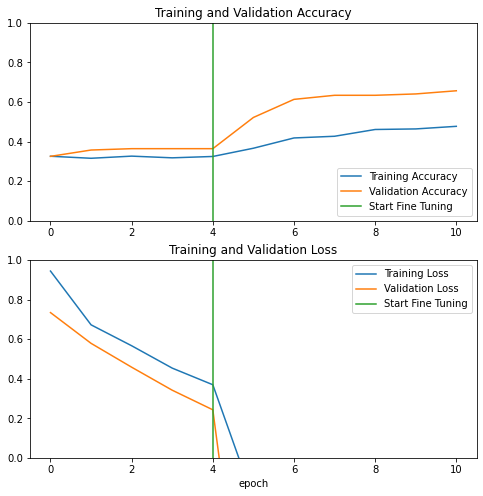

In [184]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [185]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 2s 728ms/step - loss: -4.4268 - accuracy: 0.7656
Test accuracy : 0.765625


Predictions:
 [1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0]
Labels:
 [1 0 1 2 2 2 1 0 1 0 0 1 0 0 2 0 2 2 1 0 2 1 2 2 1 1 0 0 0 1 0 0]


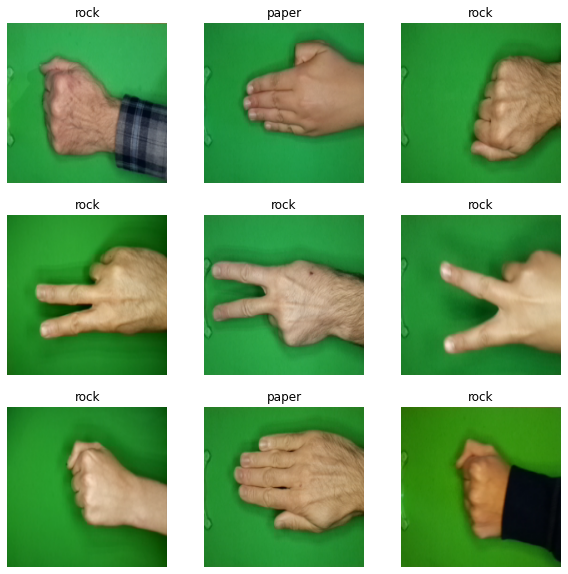

In [186]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Use Webcam (works only local)

In [190]:
#take a picture with the integrated default camera
#!pip install opencv-python
import cv2
import pymsgbox as pymsg

#access standard camera 0
videoCaptureObject = cv2.VideoCapture(0)


# OK whatever you type, it will return OK
print(msg)


#loop --> read frame and save it (set value to False)
result = True
contador = 0 
while(result):
    ret,frame = videoCaptureObject.read()
    cv2.imshow("Captura", frame)
    key = cv2.waitKey(1)
    if contador==50:
        cv2.imwrite("NewCamPicture.jpg",frame)
        result = False
    contador=contador+1
#show message 
msg = pymsg.alert("A picture was captured with the webcam.", 'Camera')
# release camera and destroy all windows
videoCaptureObject.release()
cv2.destroyAllWindows()

OK


This image most likely belongs to rock.


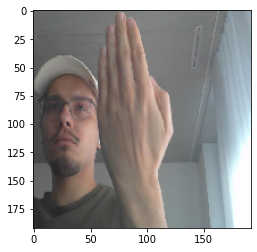

In [191]:
img = tf.keras.utils.load_img("NewCamPicture.jpg", target_size=(192,192)# your own image
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Add the image to a batch where it's the only member.


prediction = model.predict_on_batch(img_array).flatten()

prediction = tf.where(prediction < 0.5, 0, 1)


print(
    "This image most likely belongs to {}."
    .format(class_names[prediction[0]])
)

plt.imshow(img)